In [103]:
import stompy.model.delft.dflow_model as dfm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import xarray as xr
from stompy import xr_transect as xrt
import os
from stompy import utils
import stompy.plot.cmap as scmap
import numpy as np
%matplotlib notebook

In [104]:
import six
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/home/rusty/src/stompy/stompy/model/delft/dflow_model.py'>

In [105]:
turbo=scmap.load_gradient('turbo.cpt')
hot_cold=scmap.load_gradient('hot_and_cold.cpt')

In [106]:
run_dirs=[#'run_salt_20160520-v104',
          #'run_salt_20160520-v107',
          #'run_salt_20160520-v109',
          #'run_salt_20160520-v110',
          #'run_salt_20160520-v111',
          #'run_salt_20160520-v112', 
          #'run_salt_20160520-v113', 
          #'run_salt_20160520-v114', 
          #'run_salt_20160520-v115', 
          #'run_salt_20160520-v116', 
     'data_salt_filling-v01'
    
    
]

In [107]:
try:
    [h.close() for h in hiss]
except NameError:
    pass
his_fns=[os.path.join(d,'DFM_OUTPUT_flowfm/flowfm_0000_his.nc')
         for d in run_dirs]
hiss=[xr.open_dataset(his_fn) for his_fn in his_fns]
for his,d in zip(hiss,run_dirs):
    his.attrs['run_dir']=d

In [108]:
patt='thalweg_pesc.*'

trans=[dfm.extract_transect_his(his,patt) for his in hiss]

<IPython.core.display.Javascript object>


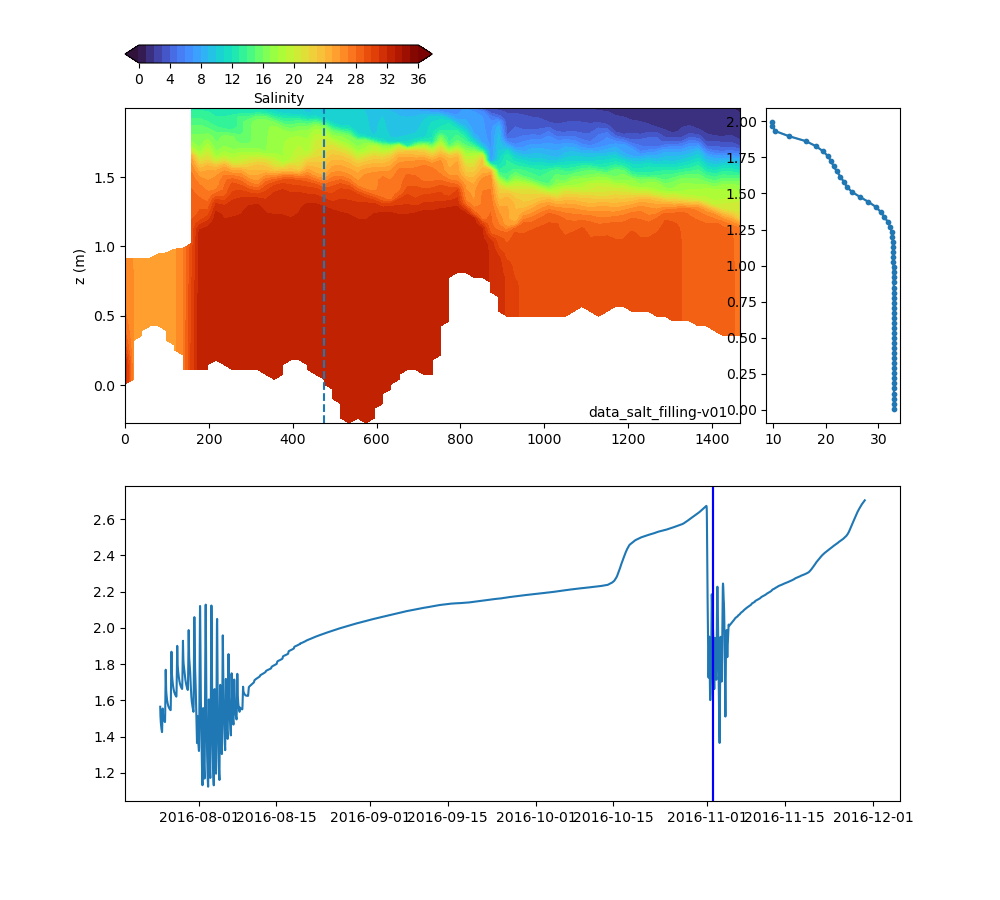

Range of salinity:  0.8291371529930466 32.97651537115318


/home/rusty/src/stompy/stompy/xr_transect.py:996: UserWarning: No contour levels were found within the data range.
  return f(x.values,yvals,scal.values,*args,**kwargs)


In [109]:
fig=plt.figure(figsize=(10,9))

G=gs.GridSpec(1+len(trans),5)

axs=[]
axv=ax=None
axvs=[]
for ti,t in enumerate(trans):
    ax=fig.add_subplot(G[ti,:-1],sharex=ax,sharey=ax)
    axs.append(ax)
    axv=fig.add_subplot(G[ti,-1],sharex=axv,sharey=axv)
    axvs.append(axv)

    
top_pos=axs[0].get_position()

cax=fig.add_axes( [top_pos.xmin,top_pos.ymax+0.05,0.5*top_pos.width,0.02])

t=np.datetime64("2016-11-02T00:00")
#t=np.datetime64("2016-06-13T22:00")
#t=np.datetime64("2016-06-12T22:00")
dist=475 # pull a profile from here.
#dist=185 # just inside mouth

V=np.linspace(0,36,37)

ttrans=[tran.isel(
        time=min(np.searchsorted(tran.time.values,t),
                 tran.dims['time']-1) )
     for tran in trans]
    

for ax,tran in zip(axs,ttrans):
    xrt.get_d_sample(tran)
    cset=xrt.contourf(tran,'salinity',V,ax=ax,cmap=turbo,extend='both')
    ax.set_ylabel('z (m)')
    xrt.contour(tran,'salinity',np.r_[33.0],ax=ax,colors='k')
    print("Range of salinity: ",float(tran['salinity'].min()),
          float(tran['salinity'].max()))

plt.colorbar(cset,cax=cax,label='Salinity',orientation='horizontal')

sampxy=None
for ax,axv,tran in zip(axs,axvs,ttrans):
    txy=np.c_[ tran.x_sample.values, tran.y_sample.values]
    if sampxy is None:
        samp=np.searchsorted(tran.d_sample.values,dist)
        sampxy=txy[samp]
    else:
        dists=utils.dist(sampxy, txy)
        samp=np.argmin(dists)
    axv.plot(tran['salinity'].isel(sample=samp),
             tran['z_ctr'].isel(sample=samp),
             marker='.')
    ax.axvline(tran.d_sample.values[samp],ls='--')
    ax.text(0.98,0.02,tran.attrs['run_dir'],transform=ax.transAxes,
            ha='right')
    # ghosted on other axes:
    for ax_other in axvs:
        if ax_other!=ax:
            ax_other.plot(tran['salinity'].isel(sample=samp),
                          tran['z_ctr'].isel(sample=samp),
                          color='0.75',marker='.',zorder=-1)
            

axt=fig.add_subplot(G[-1,:])
axt.plot( hiss[0].time, hiss[0]['waterlevel'].isel(stations=7),label='NCK waterlevel')

for tran in ttrans:
    axt.axvline( tran.time.values,color='k')
    
axt.axvline(t,color='b')

<IPython.core.display.Javascript object>


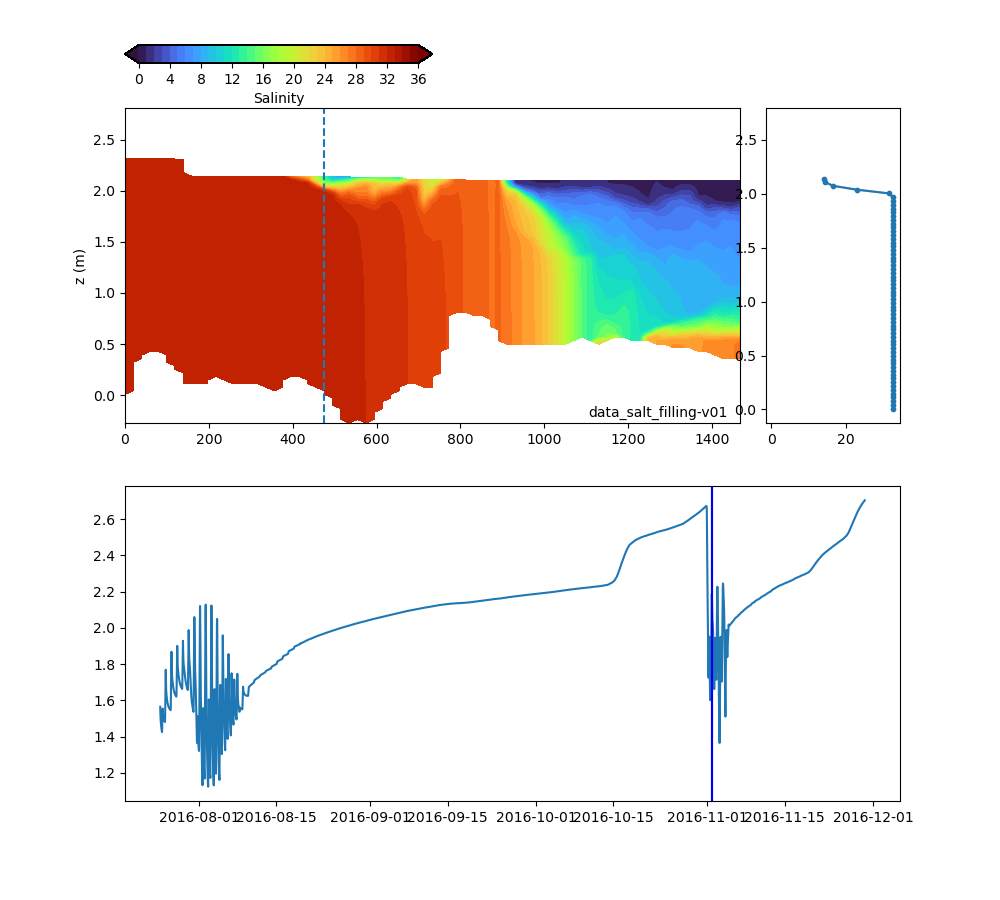

IntSlider(value=0, continuous_update=False, description='Time step:', max=12238)

In [118]:
# How to animate those sections:
fig=plt.figure(figsize=(10,9))

G=gs.GridSpec(1+len(trans),5)

axs=[]
axv=ax=None
axvs=[]
for ti,t in enumerate(trans):
    ax=fig.add_subplot(G[ti,:-1],sharex=ax,sharey=ax)
    axs.append(ax)
    axv=fig.add_subplot(G[ti,-1],sharex=axv,sharey=axv)
    axvs.append(axv)
    ax.text(0.98,0.02,t.attrs['run_dir'],transform=ax.transAxes,
            ha='right')
    
top_pos=axs[0].get_position()

cax=fig.add_axes( [top_pos.xmin,top_pos.ymax+0.05,0.5*top_pos.width,0.02])
    
t=np.datetime64("2016-06-16T12:00")
#t=np.datetime64("2016-06-13T22:00")
#t=np.datetime64("2016-06-12T22:00")
dist=475 # pull a profile from here.
#dist=185 # just inside mouth

V=np.linspace(0,36,37)
axt=fig.add_subplot(G[-1,:])
axt.plot( hiss[0].time, hiss[0]['waterlevel'].isel(stations=7),label='NCK waterlevel')

def freeze(fig):
    return [ dict(collections=list(ax.collections),lines=list(ax.lines)) 
             for ax in fig.axes ]
def thaw(fig,state):
    for ax,ax_state in zip(fig.axes,state):
        for k in ax_state:
            setattr(ax,k,list(ax_state[k]))
frozen=freeze(fig)

def draw(t):
    thaw(fig,frozen)
    ttrans=[tran.isel(
            time=min(np.searchsorted(tran.time.values,t),
                     tran.dims['time']-1) )
         for tran in trans]


    for ax,tran in zip(axs,ttrans):
        xrt.get_d_sample(tran)
        cset=xrt.contourf(tran,'salinity',V,ax=ax,cmap=turbo,extend='both')
        ax.set_ylabel('z (m)')

    plt.colorbar(cset,cax=cax,label='Salinity',orientation='horizontal')

    sampxy=None
    for ax,axv,tran in zip(axs,axvs,ttrans):
        txy=np.c_[ tran.x_sample.values, tran.y_sample.values]
        if sampxy is None:
            samp=np.searchsorted(tran.d_sample.values,dist)
            sampxy=txy[samp]
        else:
            dists=utils.dist(sampxy, txy)
            samp=np.argmin(dists)
        axv.plot(tran['salinity'].isel(sample=samp),
                 tran['z_ctr'].isel(sample=samp),
                 marker='.',color='tab:Blue')
        ax.axvline(tran.d_sample.values[samp],ls='--')

        # ghosted on other axes:
        for ax_other in axvs:
            if ax_other!=ax:
                ax_other.plot(tran['salinity'].isel(sample=samp),
                              tran['z_ctr'].isel(sample=samp),
                              color='0.75',marker='.',zorder=-1)



    for tran in ttrans:
        axt.axvline( tran.time.values,color='k')

    axt.axvline(t,color='b')


import ipywidgets as widgets
slider=widgets.IntSlider(
    min=0,
    max=len(his.time)-1,
    step=1,
    description='Time step:',
    continuous_update=False,
    orientation='horizontal',
)
slider.observe(lambda change: draw(his.time.values[change['new']]),
               names='value')
#draw(his.time.values[-1])
slider

In [113]:
model=dfm.DFlowModel.load(run_dirs[0])

In [114]:
from stompy.grid import multi_ugrid
mu=multi_ugrid.MultiUgrid(model.map_outputs())

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

<IPython.core.display.Javascript object>


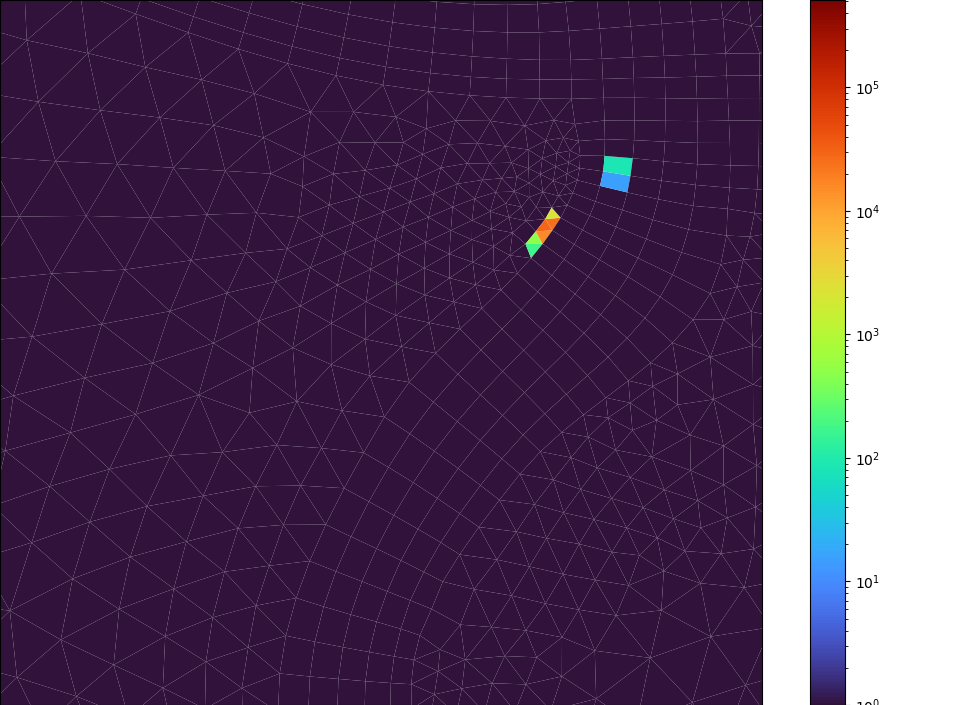

In [119]:
from matplotlib import colors
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.set_adjustable('datalim')
ccoll=mu.grid.plot_cells(values=mu.isel(time=-1)['mesh2d_Numlimdt'].values.clip(1),
                         norm=colors.LogNorm(),cmap='turbo')
plt.colorbar(ccoll)
#ax.axis('tight')
#ax.axis()

In [121]:
mu.dss[0]

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 9000, mesh2d_nFaces: 5517, mesh2d_nInterfaces: 101, mesh2d_nLayers: 100, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3484, time: 42)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.525e+05 ... 5.53e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.124e+06 ... 4.125e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.525e+05 ... 5.53e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.124e+06 ... 4.125e+06
  * time                         (time) datetime64[ns] 2016-07-25 ... 2016-10-15
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nInterfaces, mesh2d_nLayers, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 ...
    mesh2d                       int32 ...
    mesh2d_node_z                (mesh2d_nNodes) float64 2.252 2.281 ... 1.93
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 1 2 1 ... 3484 3468
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_edge_faces            (mesh2d_nEdges, Two) float64 1.0 2.0 ... 0.0
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_layer_z               (mesh2d_nLayers) float64 ...
    mesh2d_interface_z           (mesh2d_nInterfaces) float64 ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 1.0 1.0 1.0 ... 3.0 3.0
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 14.87 15.18 ... 13.55
    mesh2d_flowelem_bl           (mesh2d_nFaces) float64 2.281 2.252 ... 1.873
    mesh2d_flowelem_domain       (mesh2d_nFaces) float64 1.0 1.0 1.0 ... 5.0 5.0
    mesh2d_flowelem_globalnr     (mesh2d_nFaces) float64 2.644e+04 ... 5.888e+04
    timestep                     (time) float64 ...
    mesh2d_Numlimdt              (time, mesh2d_nFaces) float64 ...
    mesh2d_waterdepth            (time, mesh2d_nFaces) float64 ...
    mesh2d_s1                    (time, mesh2d_nFaces) float64 ...
    mesh2d_ucmag                 (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucmaga                (time, mesh2d_nFaces) float64 ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 ...
    mesh2d_sa1                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_tem1                  (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         D-Flow FM 1.2.110.67911. Model:
    history:        Created on 2021-11-11T05:38:40-0800, D-Flow FM
    date_created:   2021-11-11T05:38:40-0800
    date_modified:  2021-11-11T05:38:40-0800
    Conventions:    CF-1.8 UGRID-1.0 Deltares-0.10

<IPython.core.display.Javascript object>


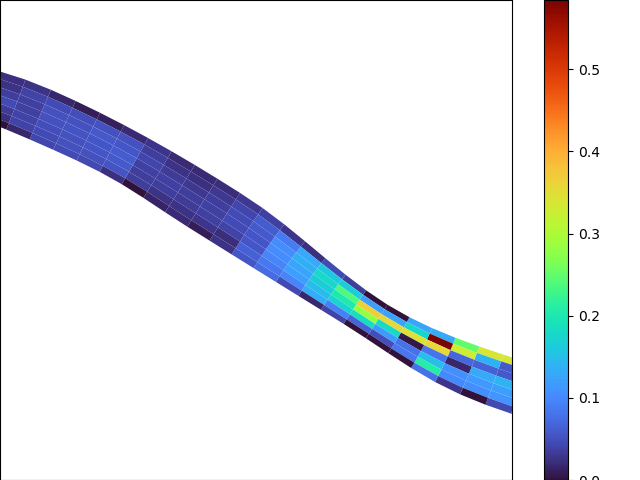

In [122]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.set_adjustable('datalim')
ccoll=mu.grid.plot_cells(values=mu.isel(time=-1)['mesh2d_ucmaga'].values,cmap='turbo')
plt.colorbar(ccoll)

In [120]:
numlimdt=mu.isel(time=-1)['mesh2d_Numlimdt'].values
d_dt_numlimdt=numlimdt - mu.isel(time=-2)['mesh2d_Numlimdt'].values

mu.grid.write_cells_shp('cell_numlimdt.shp',extra_fields=[('numlimdt',numlimdt),
                                                          ('dnumlimdt',d_dt_numlimdt)])


0%
0.7%
1.4%
2.1%
2.8%
3.5%
4.2%
4.9%
5.6%
6.3%
7%
7.7%
8.4%
9%
9.7%
10%
11%
12%
13%
13%
14%
15%
15%
16%
17%
17%
18%
19%
19%
20%
21%
22%
22%
23%
24%
24%
25%
26%
26%
27%
28%
29%
29%
30%
31%
31%
32%
33%
33%
34%
35%
35%
36%
37%
38%
38%
39%
40%
40%
41%
42%
42%
43%
44%
45%
45%
46%
47%
47%
48%
49%
49%
50%
51%
52%
52%
53%
54%
54%
55%
56%
56%
57%
58%
58%
59%
60%
61%
61%
62%
63%
63%
64%
65%
65%
66%
67%
68%
68%
69%
70%
70%
71%
72%
72%
73%
74%
74%
75%
76%
77%
77%
78%
79%
79%
80%
81%
81%
82%
83%
84%
84%
85%
86%
86%
87%
88%
88%
89%
90%
90%
91%
92%
93%
93%
94%
95%
95%
96%
97%
97%
98%
99%
1e+02%
[('poly_id1', '<i4'), ('area', '<f8'), ('volume', '<f8'), ('depth_mean', '<f8'), ('numlimdt', '<f8'), ('dnumlimdt', '<f8')]
float valued key is area
float valued key is volume
float valued key is depth_mean
float valued key is numlimdt
float valued key is dnumlimdt
